## Build RAG with Matryoshka Embeddings and LlamaIndex

Lets Split RAG Pipeline into 5 parts:

1. Data Loading from URL
2. Chunking and convert them in Matryoshka Embeddings of different sizes
3. LanceDB as Vector Store to these Embeddings
4. Query Engine
5. Answer Generation using Query Engine

In this notebook, we will build a Retrieval-Augmented Generation(RAG) pipeline with Matryoshka Embeddings using LlamaIndex.

RAG is a technique that retrieves related documents to the user's question, combines them with LLM-base prompt, and sends them to LLMs like GPT to produce more factually accurate generation.

Here is an image illustrating the RAG process

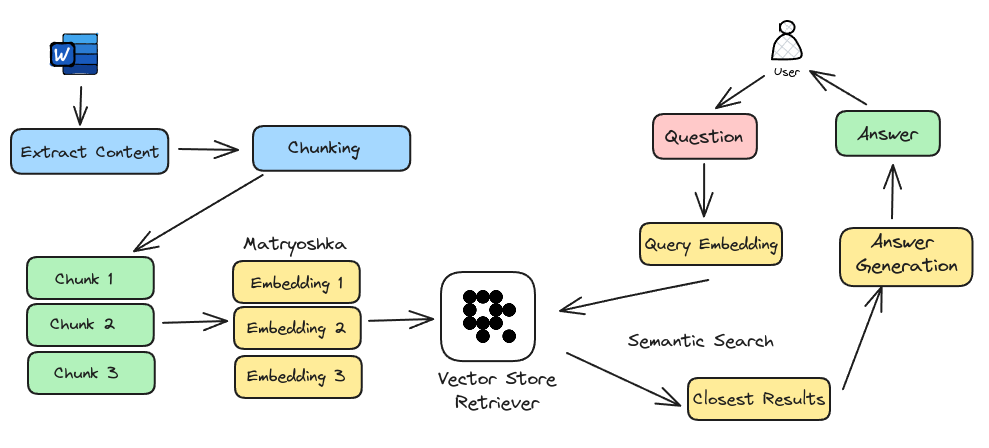

In [2]:
# install dependencies
!pip install llama-index llama-index-embeddings-huggingface llama-index-readers-web llama-index-vector-stores-lancedb diffusers huggingface-hub -q

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.1/23.1 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.6/97.6 kB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 94.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 467.7/467.7 kB 30.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 55.0 MB/

In [3]:
# import modules
from llama_index.core import VectorStoreIndex, Settings, StorageContext
from llama_index.readers.web import SimpleWebPageReader
from llama_index.vector_stores.lancedb import LanceDBVectorStore
from llama_index.llms.openai import OpenAI
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

### Set OPENAI API KEY as env variable

In [4]:
import os

# Set your OpenAI API key as env variable
os.environ["OPENAI_API_KEY"] = "sk-proj-...."

### Enter source URL for knowledgebase

In [5]:
source_url = "https://en.wikipedia.org/wiki/Deadpool_(film)"  # @param {type:"string"}

### Matryoshka Embeddings

As research progressed, new state-of-the-art text **embedding models began producing embeddings with increasingly higher output dimensions**. While this enhances performance, it also reduces the efficiency of downstream tasks such as search or classification due to the larger number of values representing each input text.

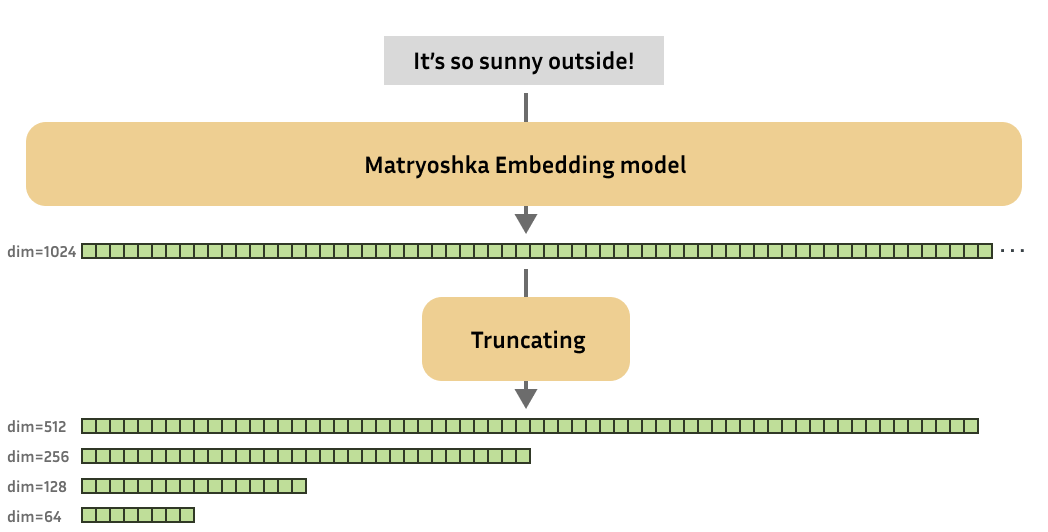
*Image Source: HuggingFace*

These Matryoshka embedding models are designed so that even small, truncated embeddings remain useful. In short, Matryoshka embedding models can generate effective embeddings of various dimensions.

### Select Matryoshka Embedding Model and respective embedding size

In [8]:
matryoshka_embedding_model = "tomaarsen/mpnet-base-nli-matryoshka"  # @param ["tomaarsen/mpnet-base-nli-matryoshka","yoshinori-sano/mpnet-base-nli-matryoshka-v2","neuml/pubmedbert-base-embeddings-matryoshka"]

matryoshka_embedding_size = "256"  # @param [768, 512, 256, 128, 64]

In [10]:
def get_doc_from_url(url):
    """
    This function reads dataset from url and returns the documents.
    """
    documents = SimpleWebPageReader(html_to_text=True).load_data([url])
    return documents


def build_RAG(
    url, matryoshka_embedding_model, matryoshka_embedding_size, uri="~/tmp/lancedb"
):
    """
    This function sets embedding model, llm and vector store to be used for creating RAG index.
    """

    Settings.embed_model = HuggingFaceEmbedding(
        model_name=matryoshka_embedding_model,
        truncate_dim=int(matryoshka_embedding_size),
    )
    Settings.llm = OpenAI()  # This will now use the API key from the environment
    documents = get_doc_from_url(url)
    vector_store = LanceDBVectorStore(uri=uri)
    storage_context = StorageContext.from_defaults(vector_store=vector_store)
    index = VectorStoreIndex.from_documents(documents, storage_context=storage_context)
    query_engine = index.as_chat_engine()

    return query_engine


query_engine = build_RAG(
    source_url, matryoshka_embedding_model, matryoshka_embedding_size
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [12]:
print("Ask a question relevant to the given context:")
while True:
    query = input("Query: ")
    response = query_engine.chat(query)
    print("Response:", response)
    if query == "exit":
        break

Ask a question relevant to the given context:
Query: Who is writer of Deadpool and what is this idea behind deadpool character
Response: The writer of Deadpool is Rhett Reese. 

The idea behind the Deadpool character was to create a unique and irreverent superhero who breaks the fourth wall, known for his sarcastic humor and self-awareness. The character was designed to be different from traditional superheroes, often making fun of superhero tropes and popular culture references. If you have any more questions or need further information, feel free to ask!
Query: How character of Deadpool is different from other Marvel superheros
Response: Deadpool is different from other Marvel superheroes in several ways. He is known for his unique characteristics such as sarcastic humor, breaking the fourth wall, and making pop culture references. Deadpool is portrayed as an antihero, engaging in morally ambiguous actions and having an unconventional approach to crime-fighting. If you have any more 

Both models were trained on the AllNLI dataset, a combination of the SNLI and MultiNLI datasets. I evaluated these models on the STSBenchmark test set using multiple embedding dimensions. The results are illustrated in the following figure:

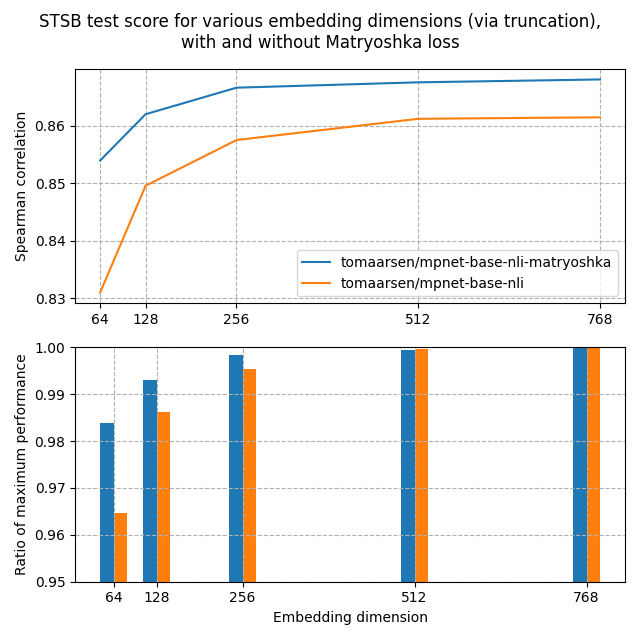

**Results:**

1. **Top Figure:** The Matryoshka model consistently achieves a higher Spearman similarity than the standard model across all dimensions, indicating its superiority in this task.

2. **Second Figure:** The Matryoshka model's performance declines much less rapidly than the standard model's. Even at just 8.3% of the full embedding size, the Matryoshka model retains 98.37% of its performance, compared to 96.46% for the standard model.

These findings suggest that truncating embeddings with a Matryoshka model can significantly:
1. Speed up downstream tasks such as retrieval.
2. Save on storage space.

All of this is achieved without a notable performance loss.